In [1]:
import pandas as pd

df = pd.DataFrame({
    "商品": ["カレーA", "カレーB", "カレーC", "カレーD", "カレーE"],
    "辛さ": [2, 5, 9, 6, 4],
    "甘さ": [9, 6, 2, 3, 4],
    "コク": [4, 6, 5, 9, 4],
    "香り": [3, 6, 7, 4, 9],
    "商品タイプ": [
        "甘口ファミリー",
        "バランス型",
        "辛口スパイシー",
        "濃厚コク重視",
        "香り特化"
    ]
})

df

,商品,辛さ,甘さ,コク,香り,商品タイプ
0,カレーA,2,9,4,3,甘口ファミリー
1,カレーB,5,6,6,6,バランス型
2,カレーC,9,2,5,7,辛口スパイシー
3,カレーD,6,3,9,4,濃厚コク重視
4,カレーE,4,4,4,9,香り特化


In [8]:
from sklearn.tree import DecisionTreeClassifier

X = df[["辛さ", "甘さ", "コク", "香り"]]
y = df["商品タイプ"]

model = DecisionTreeClassifier(
    criterion="gini", max_depth=None, random_state=0  # entropy でもOK  # 教材用に浅く
)

model.fit(X, y)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current 

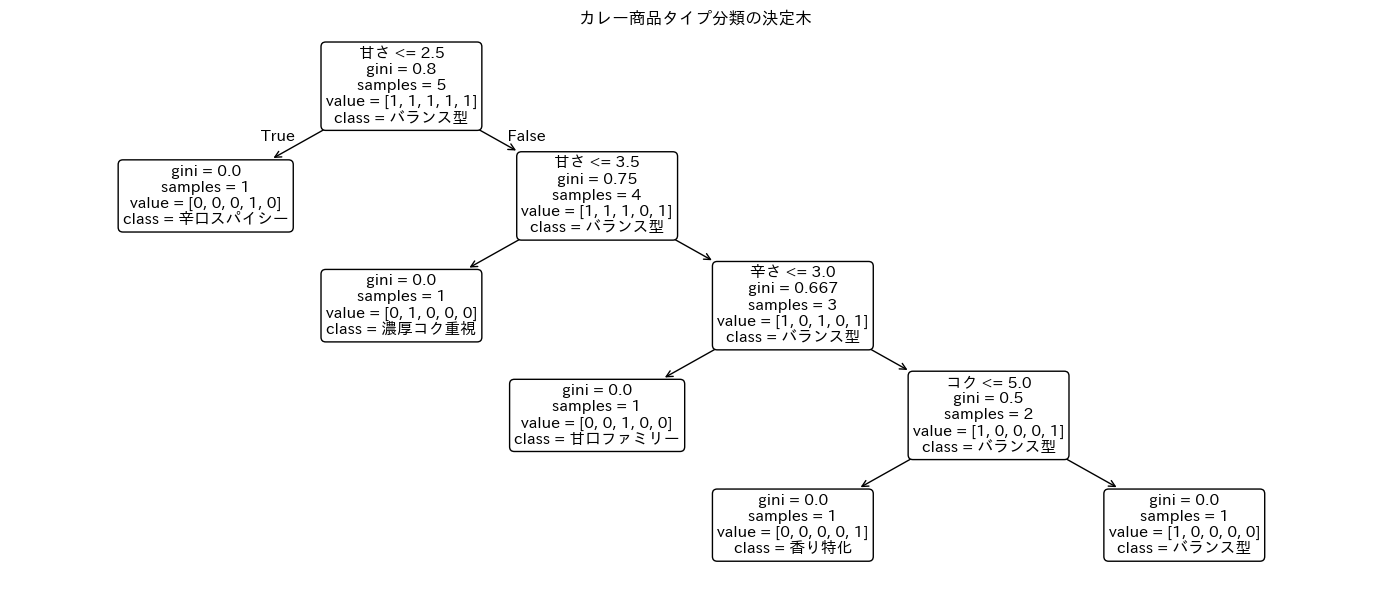

In [9]:
import matplotlib.pyplot as plt
import matplotlib_fontja
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 6))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=model.classes_,
    filled=False,
    rounded=True,
)
plt.title("カレー商品タイプ分類の決定木")
plt.tight_layout()
plt.savefig("images/dtree1.png")
plt.show()

In [10]:
# 学習済みの model がある前提
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

display(importances)
print("sum =", importances.sum())

甘さ    0.50
辛さ    0.25
コク    0.25
香り    0.00
dtype: float64

sum = 1.0


=== 元データ ===


,甘さ,香り,しっとり感,軽さ,商品タイプ
商品,,,,,
ダブルハード,9,1,3,2,甘さ特化
強熟,1,9,2,2,香り特化
元仕込,2,2,9,1,しっとり特化
ロイヤル,1,2,1,9,軽さ特化



=== 学習データでの予測 ===


,true,pred
商品,,
ダブルハード,甘さ特化,甘さ特化
強熟,香り特化,香り特化
元仕込,しっとり特化,しっとり特化
ロイヤル,軽さ特化,軽さ特化


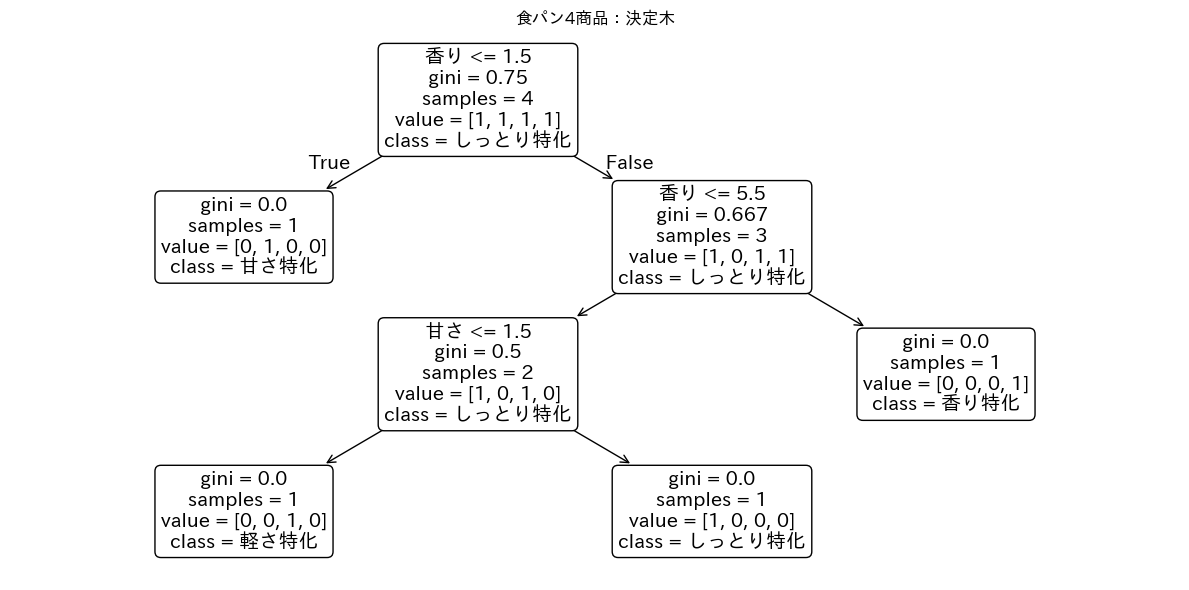


=== feature_importances_（Gini減少：正規化） ===


,importance_norm
香り,0.666667
甘さ,0.333333
しっとり感,0.000000
軽さ,0.000000



=== Gini減少：属性別（raw / norm） ===


,gini_decrease_raw,gini_decrease_norm
香り,0.50,0.666667
甘さ,0.25,0.333333
しっとり感,0.00,0.000000
軽さ,0.00,0.000000



=== ノード別：どの分岐がどれだけGiniを減らしたか ===


,node,feature,samples,gini_parent,gini_left,gini_right,delta_gini_weighted
1,2,香り,3.0,0.666667,0.5,0.000000,0.25
0,0,香り,4.0,0.750000,0.0,0.666667,0.25
2,3,甘さ,2.0,0.500000,0.0,0.000000,0.25



=== しきい値候補（参考） ===
甘さ : [np.float64(1.5), np.float64(5.5)]
香り : [np.float64(1.5), np.float64(5.5)]
しっとり感 : [np.float64(1.5), np.float64(2.5), np.float64(6.0)]
軽さ : [np.float64(1.5), np.float64(5.5)]


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja  # 日本語フォント用（環境にあれば）

from sklearn.tree import DecisionTreeClassifier, plot_tree

# -----------------------------
# 1) データ作成（食パン4商品×4属性）
# -----------------------------
df = pd.DataFrame(
    {
        "商品": ["ダブルハード", "強熟", "元仕込", "ロイヤル"],
        "甘さ": [9, 1, 2, 1],
        "香り": [1, 9, 2, 2],
        "しっとり感": [3, 2, 9, 1],
        "軽さ": [2, 2, 1, 9],
    }
).set_index("商品")

# 教師ラベル（例：それぞれの「売り」をタイプ化）
# ※教材用なので露骨に1対1対応にしています
y = pd.Series(
    ["甘さ特化", "香り特化", "しっとり特化", "軽さ特化"],
    index=df.index,
    name="商品タイプ",
)

X = df.copy()

print("=== 元データ ===")
display(pd.concat([X, y], axis=1))

# -----------------------------
# 2) 決定木（分類）を学習
# -----------------------------
model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,  # 深さ制限なし（木が完全に分かれるまで）
    random_state=0,
)
model.fit(X, y)

print("\n=== 学習データでの予測 ===")
pred = model.predict(X)
display(pd.DataFrame({"true": y, "pred": pred}, index=X.index))

# -----------------------------
# 3) 決定木の可視化
# -----------------------------
plt.figure(figsize=(12, 6))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=model.classes_,
    filled=False,
    rounded=True,
)
plt.title("食パン4商品：決定木")
plt.tight_layout()
plt.savefig("images/dtree_ex2.png")
plt.show()

# -----------------------------
# 4) 属性重要度（Gini減少ベース：正規化済み）
# -----------------------------
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)
print("\n=== feature_importances_（Gini減少：正規化） ===")
display(importances.to_frame("importance_norm"))


# -----------------------------
# 5) Gini impurity 減少（raw と norm）をノードごとに足し上げて確認
# -----------------------------
def gini_decrease_by_feature(model, feature_names):
    tree = model.tree_
    n_features = len(feature_names)

    feature = tree.feature  # 分岐特徴index（葉は -2）
    impurity = tree.impurity
    n_node_samples = tree.weighted_n_node_samples
    children_left = tree.children_left
    children_right = tree.children_right

    total_samples = n_node_samples[0]
    dec_raw = np.zeros(n_features, dtype=float)

    # ノードごとの詳細も保存
    rows = []

    for node in range(tree.node_count):
        f = feature[node]
        if f < 0:
            continue  # 葉

        left = children_left[node]
        right = children_right[node]

        # 重み付きGini減少（定義通り）
        w_parent = n_node_samples[node] / total_samples
        w_left = n_node_samples[left] / n_node_samples[node]
        w_right = n_node_samples[right] / n_node_samples[node]

        delta = w_parent * (
            impurity[node] - (w_left * impurity[left] + w_right * impurity[right])
        )
        dec_raw[f] += delta

        rows.append(
            {
                "node": node,
                "feature": feature_names[f],
                "samples": n_node_samples[node],
                "gini_parent": impurity[node],
                "gini_left": impurity[left],
                "gini_right": impurity[right],
                "delta_gini_weighted": delta,
            }
        )

    dec_norm = dec_raw / dec_raw.sum() if dec_raw.sum() > 0 else dec_raw

    feat_df = pd.DataFrame(
        {"gini_decrease_raw": dec_raw, "gini_decrease_norm": dec_norm},
        index=feature_names,
    ).sort_values("gini_decrease_norm", ascending=False)

    node_df = pd.DataFrame(rows).sort_values("delta_gini_weighted", ascending=False)

    return feat_df, node_df


feat_df, node_df = gini_decrease_by_feature(model, list(X.columns))

print("\n=== Gini減少：属性別（raw / norm） ===")
display(feat_df)

print("\n=== ノード別：どの分岐がどれだけGiniを減らしたか ===")
display(node_df)


# -----------------------------
# 6) 参考：手計算問題に対応する「候補しきい値」を列挙したい場合
# -----------------------------
# 連続値の決定木は、各特徴の「隣接する値の中点」をしきい値候補として使うのが基本
def candidate_thresholds(series):
    vals = np.sort(series.unique())
    return [(vals[i] + vals[i + 1]) / 2 for i in range(len(vals) - 1)]


print("\n=== しきい値候補（参考） ===")
for col in X.columns:
    print(col, ":", candidate_thresholds(X[col]))